In [1]:
# on-policy first-visit MC Control, SARSA, Q-Learning

In [2]:
import warnings ; warnings.filterwarnings('ignore')

import itertools
import gym, gym_walk, gym_aima
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [4]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi

In [5]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [6]:
def print_state_value_function(V, P, n_cols=4, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{:.2f}'.format(v).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [7]:
def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=2, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'er')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [8]:
def probability_success(env, pi, goal_state, iterations=1000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        while not done:
            state, _, done, _ = env.step(pi(state))
        results.append(state == goal_state)
    return np.sum(results)/len(results)

In [9]:
def mean_return(env, pi, iterations=1000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        results.append(0.0)
        while not done:
            state, reward, done, _ = env.step(pi(state))
            results[-1] += reward
    return np.mean(results)

In [10]:
def regret_accumulation(env, pi, optimal_Q, iterations=10):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        results.append(0.0)
        while not done:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            state, reward, done, _ = env.step(action)
            results[-1] += regret
    return np.mean(results)

In [11]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [12]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [13]:
def plot_value_function(title, V_track, V_true=None, log=False):
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []
    for i, state in enumerate(V_track.T):
        if not (V_true is None) and V_true[i] < 0.1:
            continue
        line_type = next(linecycler)
        label = 'Estimated V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
        if not (V_true is None):
            label = 'True v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center left', bbox_to_anchor=(1.1+loc*0.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes')
    plt.show()

In [14]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, t):
    decay_steps = int(max_steps * decay_ratio) - 2
    rem_steps = max_steps - decay_steps - 2
    values = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    values = values * (init_value - min_value) + min_value   
    values = np.hstack((init_value, values, min_value)) 
    values = np.pad(values, (0, rem_steps), 'edge')
    return values[t]

In [15]:
env = gym.make('NoisyWalkSeven-v0')
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, 0.99)
print_state_value_function(optimal_V, P, n_cols=9, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', '>'), 
                            prec=5, 
                            title='Optimal action-value function:')
print()

print_policy(optimal_pi, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, optimal_pi, goal_state=8)*100, 
    mean_return(env, optimal_pi)))

Optimal state-value function:
|           | 01   0.56 | 02   0.76 | 03   0.84 | 04   0.89 | 05   0.92 | 06   0.95 | 07   0.98 |           |

Optimal action-value function:
╒═════╤═════════╤═════════╕
│   s │       < │       > │
╞═════╪═════════╪═════════╡
│   0 │ 0       │ 0       │
├─────┼─────────┼─────────┤
│   1 │ 0.31194 │ 0.56374 │
├─────┼─────────┼─────────┤
│   2 │ 0.67026 │ 0.76304 │
├─────┼─────────┼─────────┤
│   3 │ 0.80324 │ 0.84489 │
├─────┼─────────┼─────────┤
│   4 │ 0.8638  │ 0.88924 │
├─────┼─────────┼─────────┤
│   5 │ 0.90143 │ 0.92199 │
├─────┼─────────┼─────────┤
│   6 │ 0.93219 │ 0.95153 │
├─────┼─────────┼─────────┤
│   7 │ 0.96127 │ 0.9806  │
├─────┼─────────┼─────────┤
│   8 │ 0       │ 0       │
╘═════╧═════════╧═════════╛

Policy:
|           | 01      > | 02      > | 03      > | 04      > | 05      > | 06      > | 07      > |           |
Reaches goal 97.90%. Obtains an average undiscounted return of 0.9790.


# MC Control

In [16]:
def generate_episode(pi, env, max_steps=20):
    done, episode = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = pi(state) 
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward, next_state, done))
            if done:
                break
            if t >= max_steps - 1:
                episode = []
                break
            state = next_state
    return np.array(episode, np.object)

In [17]:
class ESoftPolicy:
    def __init__(self, nS, nA, epsilon=0.2):
        self.nA = nA
        self.nS = nS
        self.epsilon = epsilon
        self.probs = np.random.dirichlet(np.ones(self.nA), size=self.nS)
        for state in range(self.nS):
            action = np.random.randint(self.nA)
            self.adjust_probs(state, action, epsilon)

    def __getitem__(self, state):
        return np.random.choice(self.nA, p=self.probs[state])

    def __call__(self, state):
        return np.random.choice(self.nA, p=self.probs[state])

    def adjust_probs(self, state, best_action, epsilon):
        self.epsilon = epsilon
        prob_best = 1 - self.epsilon + self.epsilon/self.nA
        prob_other = self.epsilon/self.nA
        new_probs = [prob_other,] * (self.nA - 1)
        new_probs.insert(best_action, prob_best)
        self.probs[state] = new_probs

In [18]:
def on_policy_mc_control(env,
                         gamma=1.0,
                         init_alpha=0.5,
                         min_alpha=0.01,
                         alpha_decay_ratio=0.3,
                         init_epsilon=1.0,
                         min_epsilon=0.1,
                         epsilon_decay_ratio=0.9,
                         n_episodes=5000,
                         max_steps=100):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS, nA = env.observation_space.n, env.action_space.n
    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False)    
    pi_track = []
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    pi = ESoftPolicy(nS, nA, init_epsilon)

    for t in tqdm(range(n_episodes)):
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        epsilon = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes, t)        
        episode = generate_episode(pi, env, max_steps)
        return_visited = np.zeros((nS, nA), dtype=bool)
        for step_idx, (state, action, reward, _, _) in enumerate(episode):
            if return_visited[state][action]:
                continue
            return_visited[state][action] = True
            
            seq_len = len(episode[step_idx:])
            G = np.sum(discounts[:seq_len] * episode[step_idx:, 2])
            Q[state][action] = Q[state][action] + alpha * (G - Q[state][action])

        Q_track[t] = Q
        pi_track.append(np.argmax(Q, axis=1))

        _, uidxs = np.unique(episode[:,0], return_index=True)
        for idx in uidxs:
            state, action, reward, _, _ = episode[idx]
            best_action = np.argmax(Q[state])
            pi.adjust_probs(state, best_action, epsilon)

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [19]:
Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = on_policy_mc_control(env, gamma=0.99)

In [20]:
print_state_value_function(V_mc, P, n_cols=9, title='State-value function found by MC:')
print_state_value_function(optimal_V, P, n_cols=9, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=9, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=5, 
                            title='MC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_mc, goal_state=8)*100))

State-value function found by MC:
|           | 01   0.54 | 02   0.72 | 03   0.83 | 04   0.88 | 05   0.92 | 06   0.95 | 07   0.98 |           |
Optimal state-value function:
|           | 01   0.56 | 02   0.76 | 03   0.84 | 04   0.89 | 05   0.92 | 06   0.95 | 07   0.98 |           |
State-value function errors:
|           | 01  -0.03 | 02  -0.04 | 03  -0.02 | 04  -0.01 | 05  -0.00 | 06  -0.00 | 07   0.00 |           |
State-value function RMSE: 0.0179

MC action-value function:
╒═════╤═════════╤═════════╤═════════╤═════════╤═════════╤══════════╕
│   s │       < │       > │     * < │     * > │    er < │     er > │
╞═════╪═════════╪═════════╪═════════╪═════════╪═════════╪══════════╡
│   0 │ 0       │ 0       │ 0       │ 0       │ 0       │  0       │
├─────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────┤
│   1 │ 0.22945 │ 0.53732 │ 0.31194 │ 0.56374 │ 0.08249 │  0.02642 │
├─────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────┤
│   2 │ 0.62429 │ 0.72205 │ 0.670

# SARSA

In [21]:
def sarsa(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.3,
          init_epsilon=1.0,
          min_epsilon=0.1,
          epsilon_decay_ratio=0.9,
          n_episodes=5000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for t in tqdm(range(n_episodes)):
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        epsilon = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes, t)   
        state, done = env.reset(), False
        action = select_action(state, Q, epsilon)
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilon)
            td_estimate = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_estimate - Q[state][action]
            Q[state][action] = Q[state][action] + alpha * td_error
            state, action = next_state, next_action
        Q_track[t] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [22]:
Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env)

In [23]:
print_state_value_function(V_sarsa, P, n_cols=9, title='State-value function found by SARSA:')
print_state_value_function(optimal_V, P, n_cols=9, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=9, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=5, 
                            title='SARSA action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_sarsa, goal_state=8)*100))

State-value function found by SARSA:
|           | 01   0.55 | 02   0.79 | 03   0.93 | 04   0.97 | 05   0.99 | 06   1.00 | 07   1.00 |           |
Optimal state-value function:
|           | 01   0.56 | 02   0.76 | 03   0.84 | 04   0.89 | 05   0.92 | 06   0.95 | 07   0.98 |           |
State-value function errors:
|           | 01  -0.01 | 02   0.03 | 03   0.08 | 04   0.08 | 05   0.07 | 06   0.04 | 07   0.02 |           |
State-value function RMSE: 0.0478

SARSA action-value function:
╒═════╤═════════╤═════════╤═════════╤═════════╤══════════╤══════════╕
│   s │       < │       > │     * < │     * > │     er < │     er > │
╞═════╪═════════╪═════════╪═════════╪═════════╪══════════╪══════════╡
│   0 │ 0       │ 0       │ 0       │ 0       │  0       │  0       │
├─────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┤
│   1 │ 0.22042 │ 0.55003 │ 0.31194 │ 0.56374 │  0.09152 │  0.01371 │
├─────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┤
│   2 │ 0.59939 │ 0.

# Q-Learning

In [24]:
def q_learning(env, 
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.3,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=5000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for t in tqdm(range(n_episodes)):
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        epsilon = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes, t) 
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            td_estimate = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_estimate - Q[state][action]
            Q[state][action] = Q[state][action] + alpha * td_error
            state = next_state

        Q_track[t] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [25]:
Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=0.99)

In [26]:
print_state_value_function(V_ql, P, n_cols=9, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=9, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=9, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=5, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_ql, goal_state=8)*100))

State-value function found by Q-learning:
|           | 01   0.56 | 02   0.75 | 03   0.84 | 04   0.89 | 05   0.92 | 06   0.95 | 07   0.98 |           |
Optimal state-value function:
|           | 01   0.56 | 02   0.76 | 03   0.84 | 04   0.89 | 05   0.92 | 06   0.95 | 07   0.98 |           |
State-value function errors:
|           | 01  -0.00 | 02  -0.01 | 03  -0.00 | 04  -0.00 | 05   0.00 | 06   0.00 | 07   0.00 |           |
State-value function RMSE: 0.0038

Q-learning action-value function:
╒═════╤═════════╤═════════╤═════════╤═════════╤══════════╤══════════╕
│   s │       < │       > │     * < │     * > │     er < │     er > │
╞═════╪═════════╪═════════╪═════════╪═════════╪══════════╪══════════╡
│   0 │ 0       │ 0       │ 0       │ 0       │  0       │  0       │
├─────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┤
│   1 │ 0.30862 │ 0.55891 │ 0.31194 │ 0.56374 │  0.00332 │  0.00483 │
├─────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┤
│   2 │ 0.

# Comparison of max(Q) for every episode

## Monte-Carlo

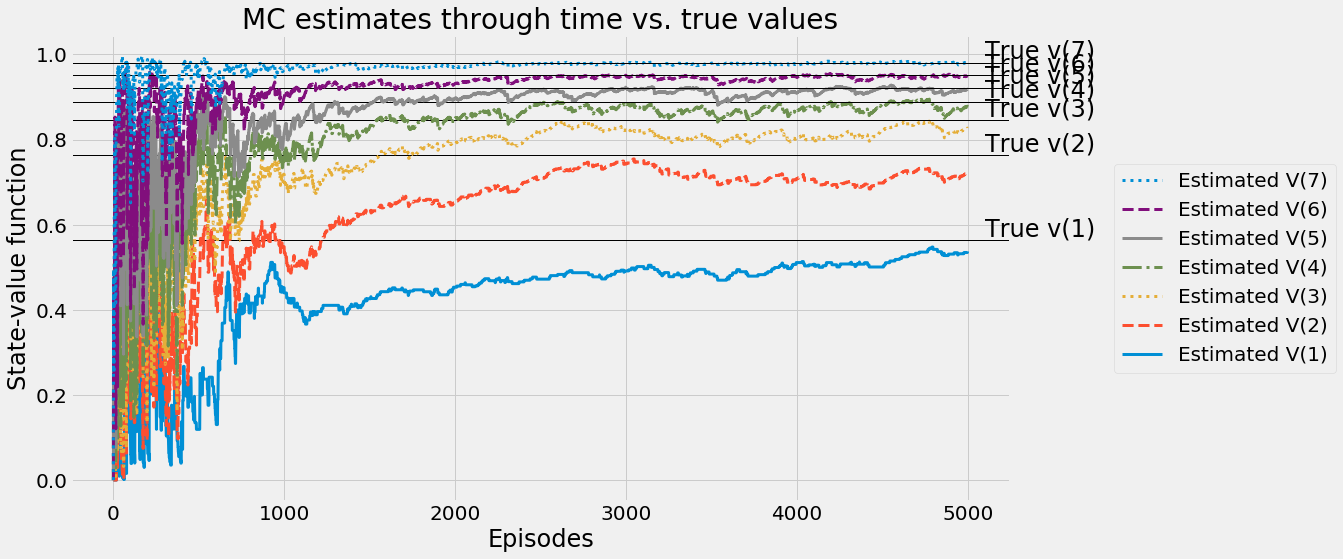

In [27]:
plot_value_function(
    'MC estimates through time vs. true values', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    log=False)

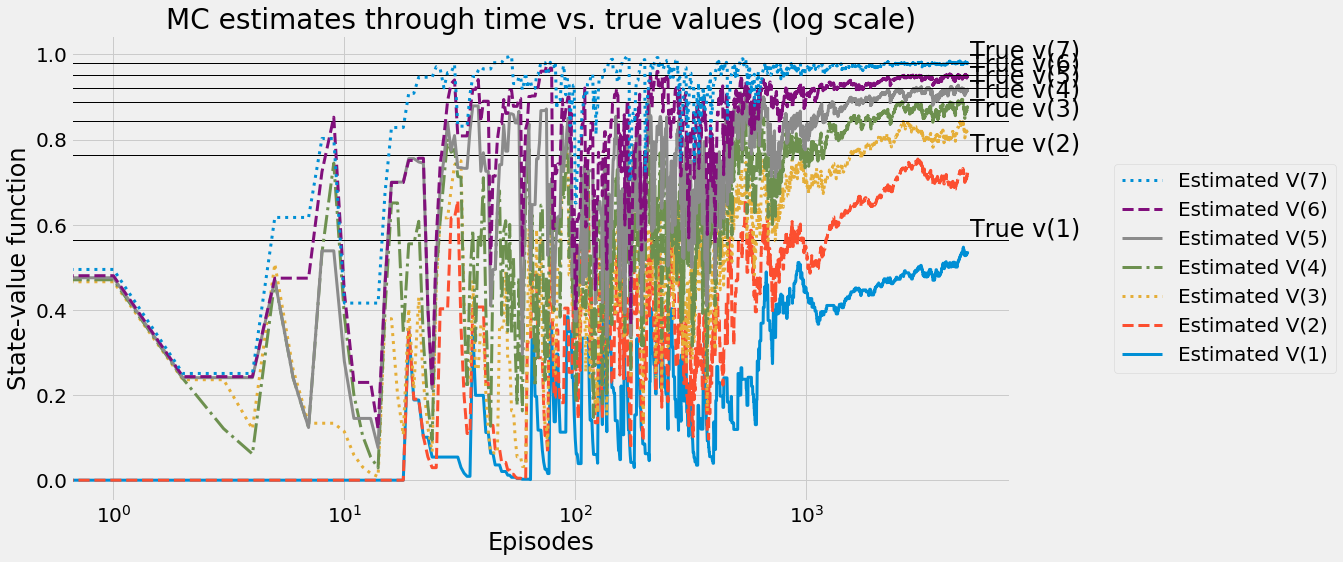

In [28]:
plot_value_function(
    'MC estimates through time vs. true values (log scale)', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    log=True)

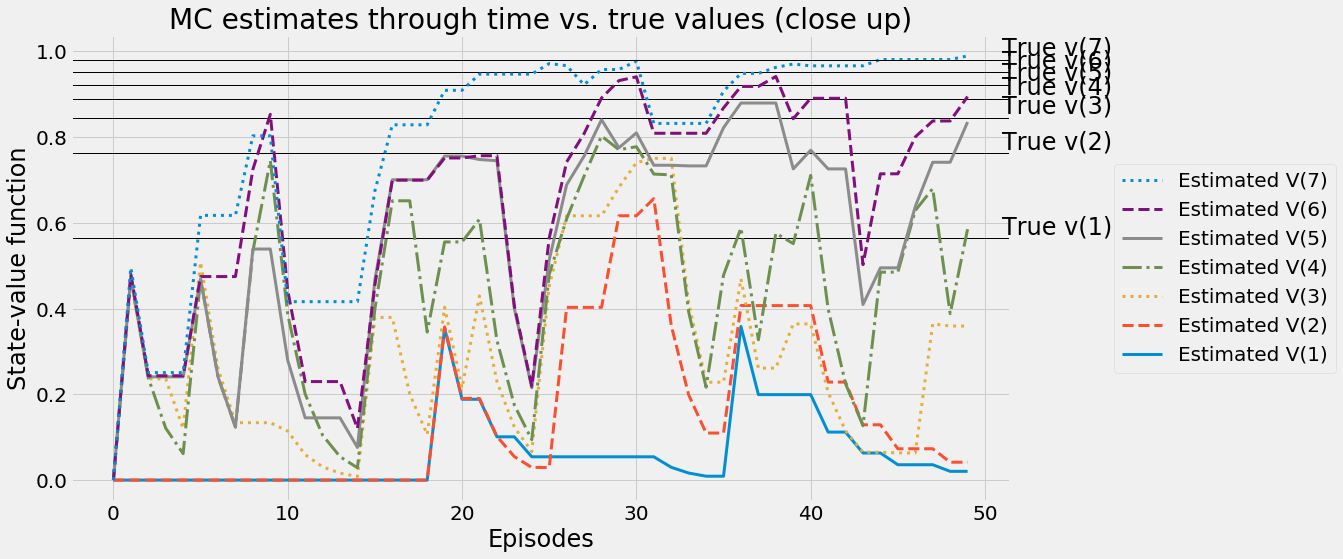

In [29]:
plot_value_function(
    'MC estimates through time vs. true values (close up)', 
    np.max(Q_track_mc, axis=2)[:50], 
    optimal_V[:50],
    log=False)

## SARSA

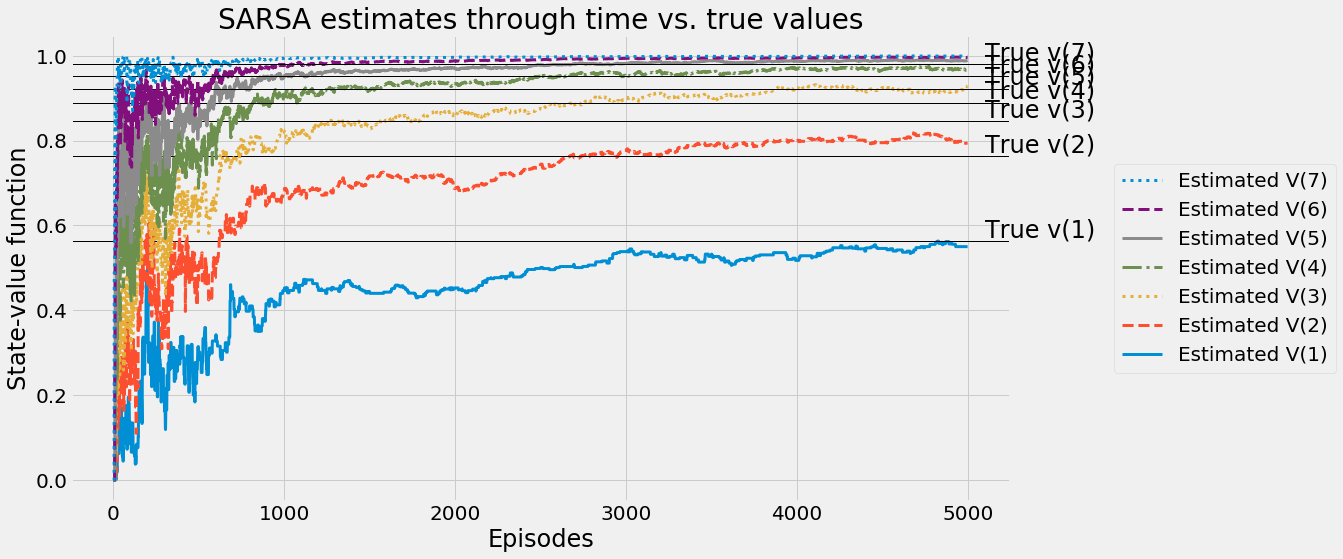

In [30]:
plot_value_function(
    'SARSA estimates through time vs. true values', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    log=False)

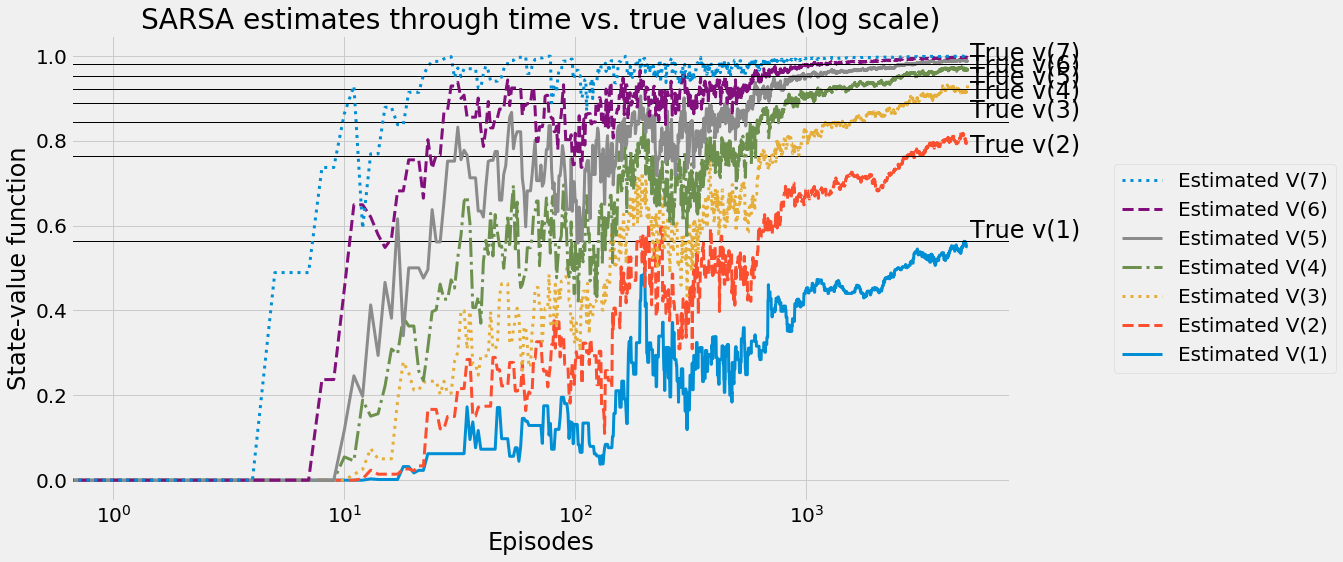

In [31]:
plot_value_function(
    'SARSA estimates through time vs. true values (log scale)', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    log=True)

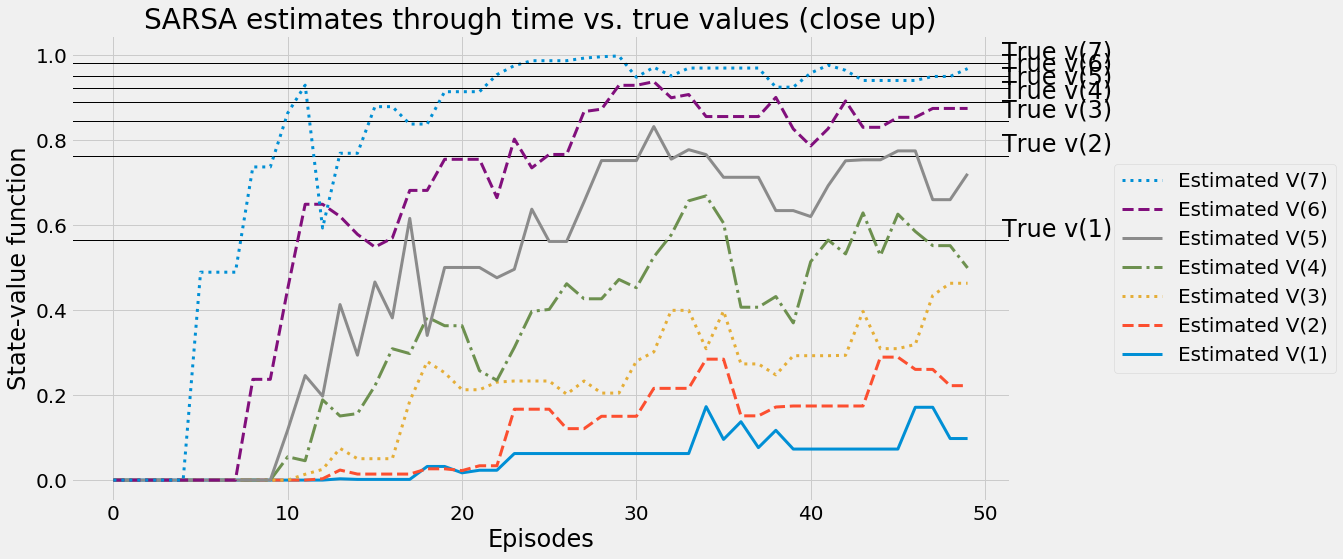

In [32]:
plot_value_function(
    'SARSA estimates through time vs. true values (close up)', 
    np.max(Q_track_sarsa, axis=2)[:50], 
    optimal_V[:50],
    log=False)

## Q-learning

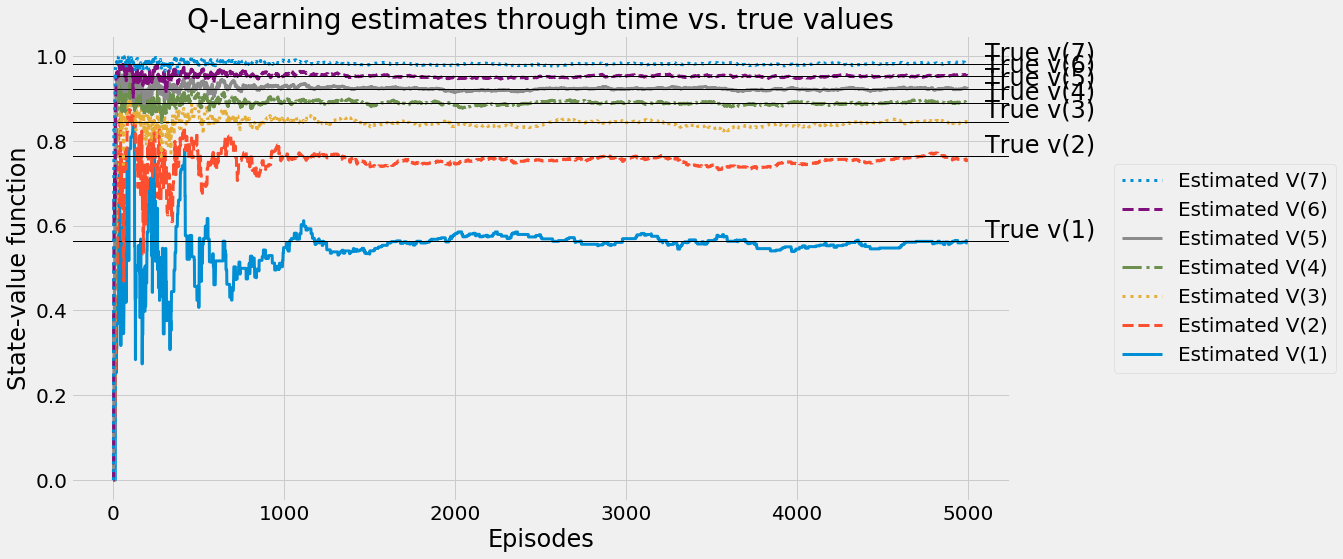

In [33]:
plot_value_function(
    'Q-Learning estimates through time vs. true values', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    log=False)

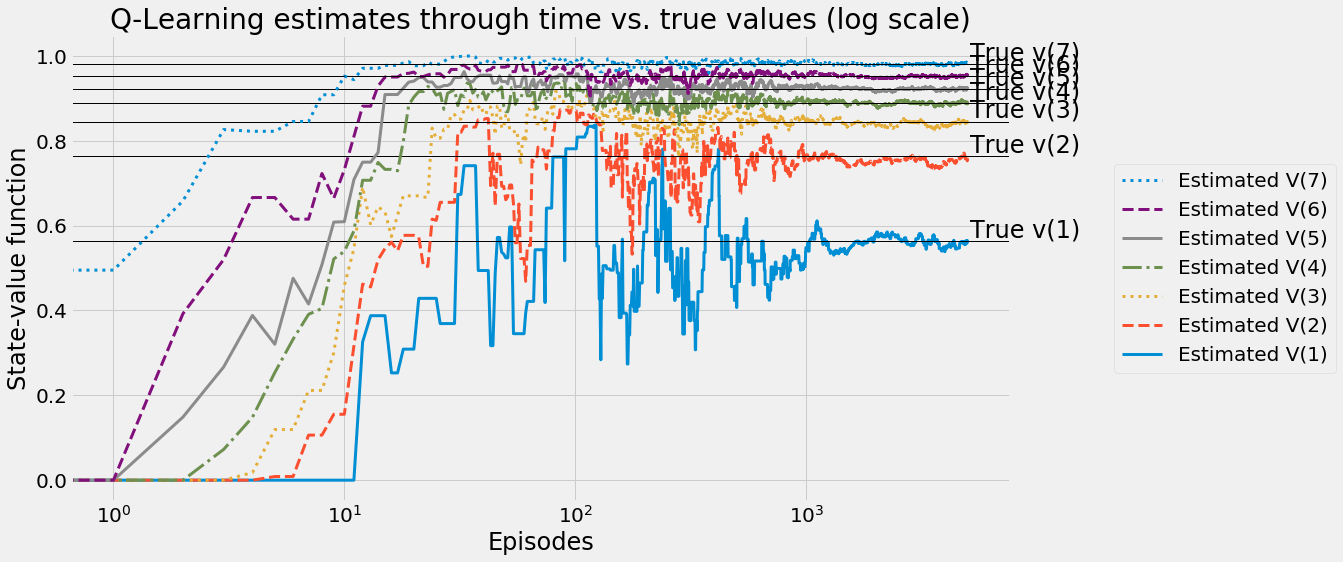

In [34]:
plot_value_function(
    'Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    log=True)

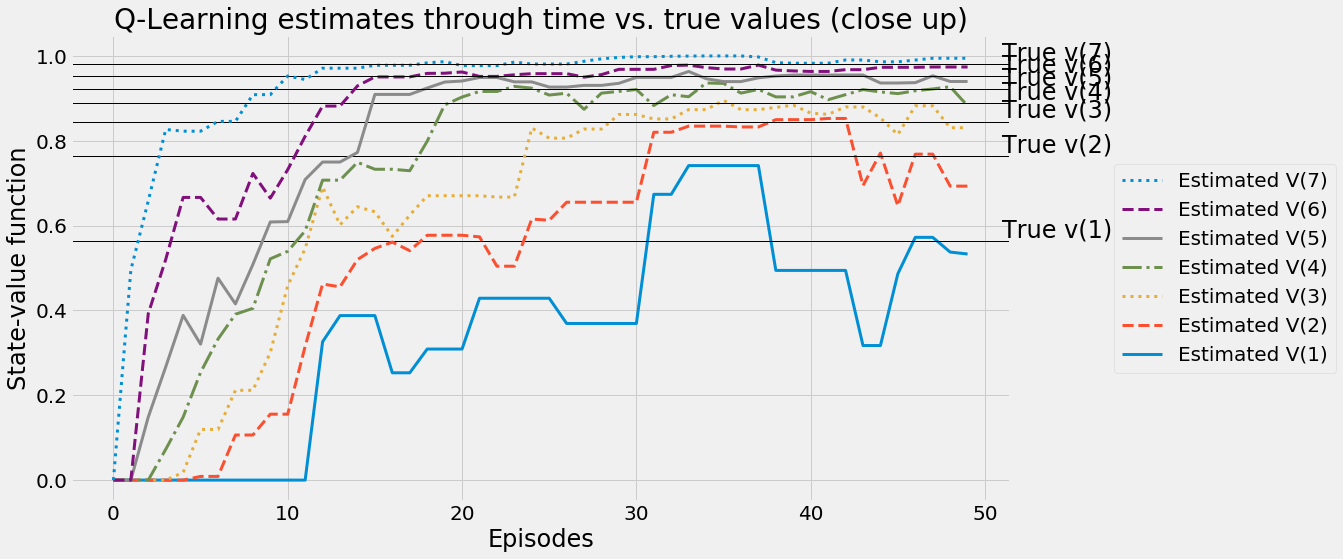

In [35]:
plot_value_function(
    'Q-Learning estimates through time vs. true values (close up)', 
    np.max(Q_track_ql, axis=2)[:50], 
    optimal_V[:50],
    log=False)

# Russell & Norvig's Gridworld

In [36]:
env = gym.make('RussellNorvigGridworld-v0')
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P)
print_state_value_function(optimal_V, P, n_cols=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=5, 
                            title='Optimal action-value function:')
print()

print_policy(optimal_pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, optimal_pi, goal_state=3)*100, 
    mean_return(env, optimal_pi)))

Optimal state-value function:
| 00   0.81 | 01   0.87 | 02   0.92 |           |
| 04   0.76 |           | 06   0.66 |           |
| 08   0.71 | 09   0.66 | 10   0.61 | 11   0.39 |

Optimal action-value function:
╒═════╤═════════╤═════════╤══════════╤══════════╕
│   s │       < │       v │        > │        ^ │
╞═════╪═════════╪═════════╪══════════╪══════════╡
│   0 │ 0.76656 │ 0.73718 │  0.81156 │  0.77718 │
├─────┼─────────┼─────────┼──────────┼──────────┤
│   1 │ 0.78281 │ 0.82718 │  0.86781 │  0.82718 │
├─────┼─────────┼─────────┼──────────┼──────────┤
│   2 │ 0.81205 │ 0.675   │  0.91781 │  0.88103 │
├─────┼─────────┼─────────┼──────────┼──────────┤
│   3 │ 0       │ 0       │  0       │  0       │
├─────┼─────────┼─────────┼──────────┼──────────┤
│   4 │ 0.72093 │ 0.67656 │  0.72093 │  0.76156 │
├─────┼─────────┼─────────┼──────────┼──────────┤
│   5 │ 0       │ 0       │  0       │  0       │
├─────┼─────────┼─────────┼──────────┼──────────┤
│   6 │ 0.64114 │ 0.41516 │ -0.68708 │

In [37]:
Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = on_policy_mc_control(env)

In [38]:
print_state_value_function(V_mc, P, n_cols=4, title='State-value function found by MC:')
print_state_value_function(optimal_V, P, n_cols=4, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='MC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_mc, goal_state=3)*100))

State-value function found by MC:
| 00   0.75 | 01   0.82 | 02   0.88 |           |
| 04   0.67 |           | 06   0.61 |           |
| 08   0.59 | 09   0.43 | 10   0.36 | 11   0.03 |
Optimal state-value function:
| 00   0.81 | 01   0.87 | 02   0.92 |           |
| 04   0.76 |           | 06   0.66 |           |
| 08   0.71 | 09   0.66 | 10   0.61 | 11   0.39 |
State-value function errors:
| 00  -0.06 | 01  -0.05 | 02  -0.03 |           |
| 04  -0.09 |           | 06  -0.05 |           |
| 08  -0.12 | 09  -0.23 | 10  -0.25 | 11  -0.35 |
State-value function RMSE: 0.1508

MC action-value function:
╒═════╤═══════╤════════╤════════╤════════╤═══════╤═══════╤════════╤════════╤════════╤════════╤════════╤════════╕
│   s │     < │      v │      > │      ^ │   * < │   * v │    * > │    * ^ │   er < │   er v │   er > │   er ^ │
╞═════╪═══════╪════════╪════════╪════════╪═══════╪═══════╪════════╪════════╪════════╪════════╪════════╪════════╡
│   0 │ 0.633 │  0.668 │  0.75  │  0.678 │ 0.767 │ 0.737 

In [39]:
Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env)

In [40]:
print_state_value_function(V_sarsa, P, n_cols=4, title='State-value function found by SARSA:')
print_state_value_function(optimal_V, P, n_cols=4, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='SARSA action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_sarsa, goal_state=3)*100))

State-value function found by SARSA:
| 00   0.76 | 01   0.83 | 02   0.90 |           |
| 04   0.69 |           | 06   0.57 |           |
| 08   0.59 | 09   0.51 | 10   0.19 | 11  -0.49 |
Optimal state-value function:
| 00   0.81 | 01   0.87 | 02   0.92 |           |
| 04   0.76 |           | 06   0.66 |           |
| 08   0.71 | 09   0.66 | 10   0.61 | 11   0.39 |
State-value function errors:
| 00  -0.06 | 01  -0.04 | 02  -0.01 |           |
| 04  -0.07 |           | 06  -0.09 |           |
| 08  -0.11 | 09  -0.14 | 10  -0.42 | 11  -0.88 |
State-value function RMSE: 0.2886

SARSA action-value function:
╒═════╤════════╤════════╤════════╤════════╤═══════╤═══════╤════════╤════════╤════════╤════════╤════════╤════════╕
│   s │      < │      v │      > │      ^ │   * < │   * v │    * > │    * ^ │   er < │   er v │   er > │   er ^ │
╞═════╪════════╪════════╪════════╪════════╪═══════╪═══════╪════════╪════════╪════════╪════════╪════════╪════════╡
│   0 │  0.615 │  0.561 │  0.756 │  0.653 │ 0.76

In [41]:
Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env)

In [42]:
print_state_value_function(V_ql, P, n_cols=4, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=4, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_ql, goal_state=3)*100))

State-value function found by Q-learning:
| 00   0.82 | 01   0.87 | 02   0.91 |           |
| 04   0.77 |           | 06   0.67 |           |
| 08   0.71 | 09   0.65 | 10   0.62 | 11   0.49 |
Optimal state-value function:
| 00   0.81 | 01   0.87 | 02   0.92 |           |
| 04   0.76 |           | 06   0.66 |           |
| 08   0.71 | 09   0.66 | 10   0.61 | 11   0.39 |
State-value function errors:
| 00   0.00 | 01   0.00 | 02  -0.00 |           |
| 04   0.00 |           | 06   0.01 |           |
| 08   0.00 | 09  -0.00 | 10   0.01 | 11   0.10 |
State-value function RMSE: 0.0296

Q-learning action-value function:
╒═════╤═══════╤═══════╤════════╤════════╤═══════╤═══════╤════════╤════════╤════════╤════════╤════════╤════════╕
│   s │     < │     v │      > │      ^ │   * < │   * v │    * > │    * ^ │   er < │   er v │   er > │   er ^ │
╞═════╪═══════╪═══════╪════════╪════════╪═══════╪═══════╪════════╪════════╪════════╪════════╪════════╪════════╡
│   0 │ 0.771 │ 0.749 │  0.816 │  0.78  │ 0.

# FrozenLake environment

In [43]:
env = gym.make('FrozenLake-v0')
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=0.99)
print_state_value_function(optimal_V, P, n_cols=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=5, 
                            title='Optimal action-value function:')
print()

print_policy(optimal_pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, optimal_pi, goal_state=15)*100, 
    mean_return(env, optimal_pi)))

Optimal state-value function:
| 00   0.54 | 01   0.50 | 02   0.47 | 03   0.46 |
| 04   0.56 |           | 06   0.36 |           |
| 08   0.59 | 09   0.64 | 10   0.62 |           |
|           | 13   0.74 | 14   0.86 |           |

Optimal action-value function:
╒═════╤═════════╤═════════╤═════════╤═════════╕
│   s │       < │       v │       > │       ^ │
╞═════╪═════════╪═════════╪═════════╪═════════╡
│   0 │ 0.54203 │ 0.52776 │ 0.52776 │ 0.52234 │
├─────┼─────────┼─────────┼─────────┼─────────┤
│   1 │ 0.34347 │ 0.3342  │ 0.31993 │ 0.4988  │
├─────┼─────────┼─────────┼─────────┼─────────┤
│   2 │ 0.43819 │ 0.43362 │ 0.42435 │ 0.4707  │
├─────┼─────────┼─────────┼─────────┼─────────┤
│   3 │ 0.30609 │ 0.30609 │ 0.30152 │ 0.45685 │
├─────┼─────────┼─────────┼─────────┼─────────┤
│   4 │ 0.55845 │ 0.37958 │ 0.37416 │ 0.36316 │
├─────┼─────────┼─────────┼─────────┼─────────┤
│   5 │ 0       │ 0       │ 0       │ 0       │
├─────┼─────────┼─────────┼─────────┼─────────┤
│   6 │ 0.35835 │ 

In [44]:
Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = on_policy_mc_control(env, gamma=0.99, n_episodes=20000)

In [45]:
print_state_value_function(V_mc, P, n_cols=4, title='State-value function found by MC:')
print_state_value_function(optimal_V, P, n_cols=4, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='MC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_mc, goal_state=15)*100))

State-value function found by MC:
| 00   0.28 | 01   0.21 | 02   0.18 | 03   0.17 |
| 04   0.30 |           | 06   0.20 |           |
| 08   0.35 | 09   0.44 | 10   0.44 |           |
|           | 13   0.58 | 14   0.77 |           |
Optimal state-value function:
| 00   0.54 | 01   0.50 | 02   0.47 | 03   0.46 |
| 04   0.56 |           | 06   0.36 |           |
| 08   0.59 | 09   0.64 | 10   0.62 |           |
|           | 13   0.74 | 14   0.86 |           |
State-value function errors:
| 00  -0.26 | 01  -0.29 | 02  -0.29 | 03  -0.29 |
| 04  -0.25 |           | 06  -0.16 |           |
| 08  -0.25 | 09  -0.21 | 10  -0.17 |           |
|           | 13  -0.16 | 14  -0.10 |           |
State-value function RMSE: 0.1898

MC action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤════════╤════════╤════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   er < │   er v │   er > │   er ^ │
╞═════╪═══════╪═══════╪═══════

In [46]:
Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env, gamma=0.99, n_episodes=20000)

In [47]:
print_state_value_function(V_sarsa, P, n_cols=4, title='State-value function found by SARSA:')
print_state_value_function(optimal_V, P, n_cols=4, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='SARSA action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_sarsa, goal_state=15)*100))

State-value function found by SARSA:
| 00   0.29 | 01   0.24 | 02   0.21 | 03   0.14 |
| 04   0.32 |           | 06   0.21 |           |
| 08   0.37 | 09   0.46 | 10   0.48 |           |
|           | 13   0.60 | 14   0.82 |           |
Optimal state-value function:
| 00   0.54 | 01   0.50 | 02   0.47 | 03   0.46 |
| 04   0.56 |           | 06   0.36 |           |
| 08   0.59 | 09   0.64 | 10   0.62 |           |
|           | 13   0.74 | 14   0.86 |           |
State-value function errors:
| 00  -0.25 | 01  -0.26 | 02  -0.26 | 03  -0.32 |
| 04  -0.24 |           | 06  -0.15 |           |
| 08  -0.22 | 09  -0.18 | 10  -0.14 |           |
|           | 13  -0.15 | 14  -0.04 |           |
State-value function RMSE: 0.1772

SARSA action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤════════╤════════╤════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   er < │   er v │   er > │   er ^ │
╞═════╪═══════╪═══════╪═

In [48]:
Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=0.99, n_episodes=20000)

In [49]:
print_state_value_function(V_ql, P, n_cols=4, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=4, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_ql, goal_state=15)*100))

State-value function found by Q-learning:
| 00   0.52 | 01   0.47 | 02   0.44 | 03   0.43 |
| 04   0.53 |           | 06   0.30 |           |
| 08   0.57 | 09   0.63 | 10   0.60 |           |
|           | 13   0.73 | 14   0.86 |           |
Optimal state-value function:
| 00   0.54 | 01   0.50 | 02   0.47 | 03   0.46 |
| 04   0.56 |           | 06   0.36 |           |
| 08   0.59 | 09   0.64 | 10   0.62 |           |
|           | 13   0.74 | 14   0.86 |           |
State-value function errors:
| 00  -0.02 | 01  -0.03 | 02  -0.03 | 03  -0.03 |
| 04  -0.02 |           | 06  -0.05 |           |
| 08  -0.02 | 09  -0.02 | 10  -0.01 |           |
|           | 13  -0.01 | 14  -0.00 |           |
State-value function RMSE: 0.022

Q-learning action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤════════╤════════╤════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   er < │   er v │   er > │   er ^ │
╞═════╪═══════╪

# Policy evolution comparison

In [50]:
mc_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_mc)])

In [51]:
sarsa_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_sarsa)])

In [52]:
ql_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_ql)])

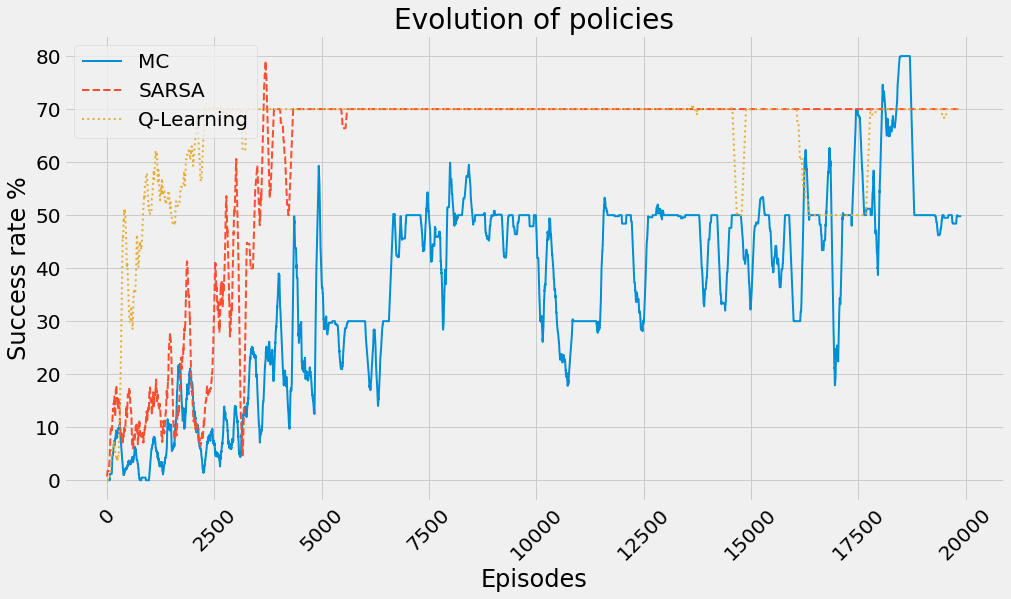

In [53]:
plt.plot(mc_success_evolution, '-', linewidth=2, label='MC')
plt.plot(sarsa_success_evolution, '--', linewidth=2, label='SARSA')
plt.plot(ql_success_evolution, ':', linewidth=2, label='Q-Learning')
plt.legend(loc=2, ncol=1)

plt.title('Evolution of policies')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.xticks(rotation=45)

plt.show()

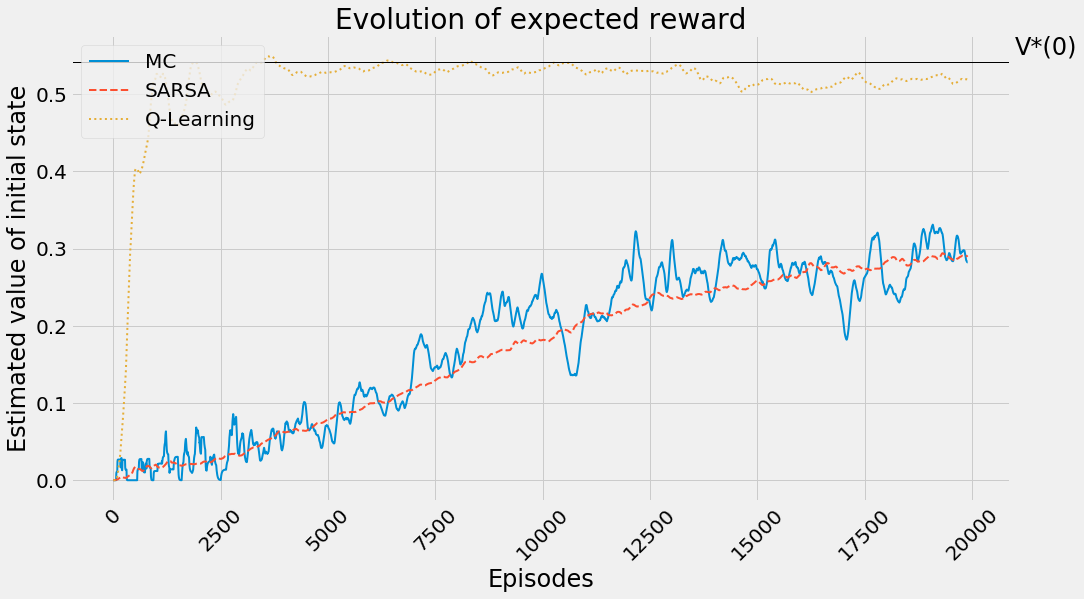

In [54]:
plt.plot(moving_average(np.max(Q_track_mc, axis=2).T[0]), 
         '-', linewidth=2, label='MC')
plt.plot(moving_average(np.max(Q_track_sarsa, axis=2).T[0]), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.max(Q_track_ql, axis=2).T[0]), 
         ':', linewidth=2, label='Q-Learning')
plt.legend(loc=2, ncol=1)

plt.axhline(y=optimal_V[0], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_mc)*1.05), optimal_V[0]+.01, 'V*(0)')


plt.title('Evolution of expected reward')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state')
plt.xticks(rotation=45)

plt.show()

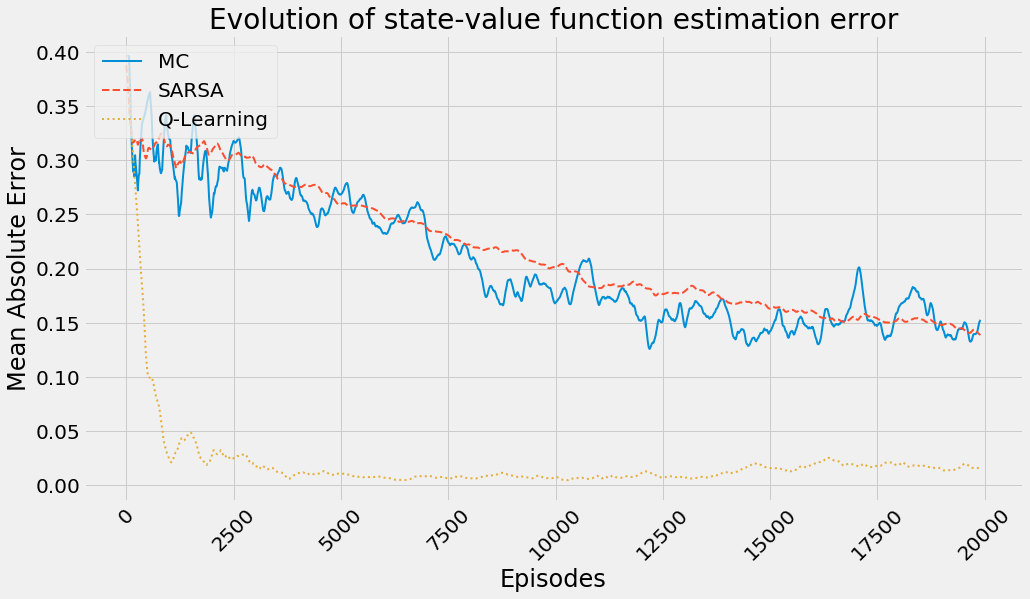

In [55]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_mc, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='MC')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sarsa, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_ql, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q-Learning')
plt.legend(loc=2, ncol=1)

plt.title('Evolution of state-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

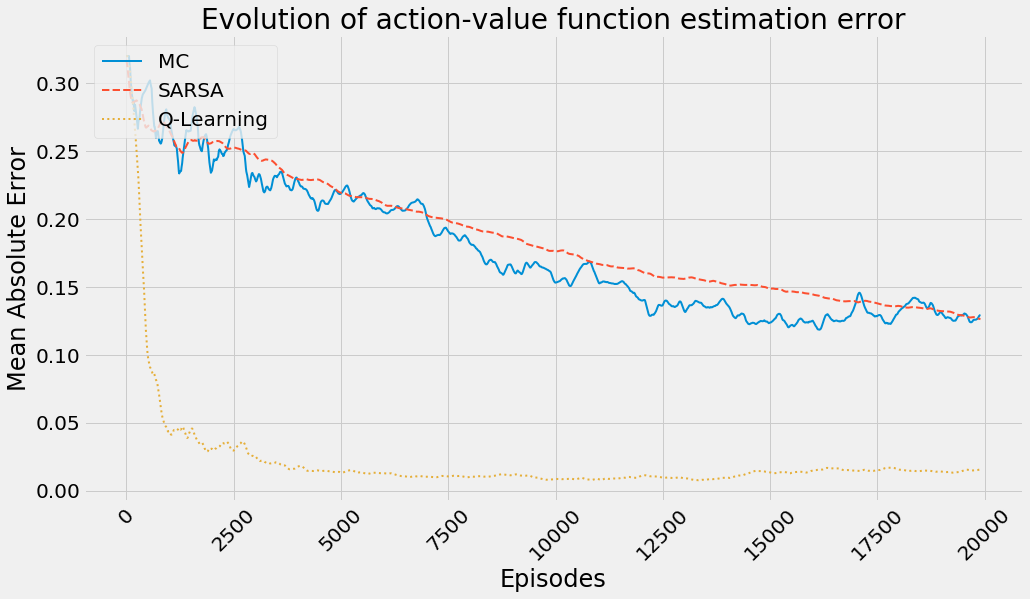

In [56]:
plt.plot(moving_average(np.mean(np.abs(Q_track_mc - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='MC')
plt.plot(moving_average(np.mean(np.abs(Q_track_sarsa - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(Q_track_ql - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Q-Learning')
plt.legend(loc=2, ncol=1)

plt.title('Evolution of action-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

In [57]:
mc_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_mc)])

In [58]:
sarsa_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_sarsa)])

In [59]:
ql_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_ql)])

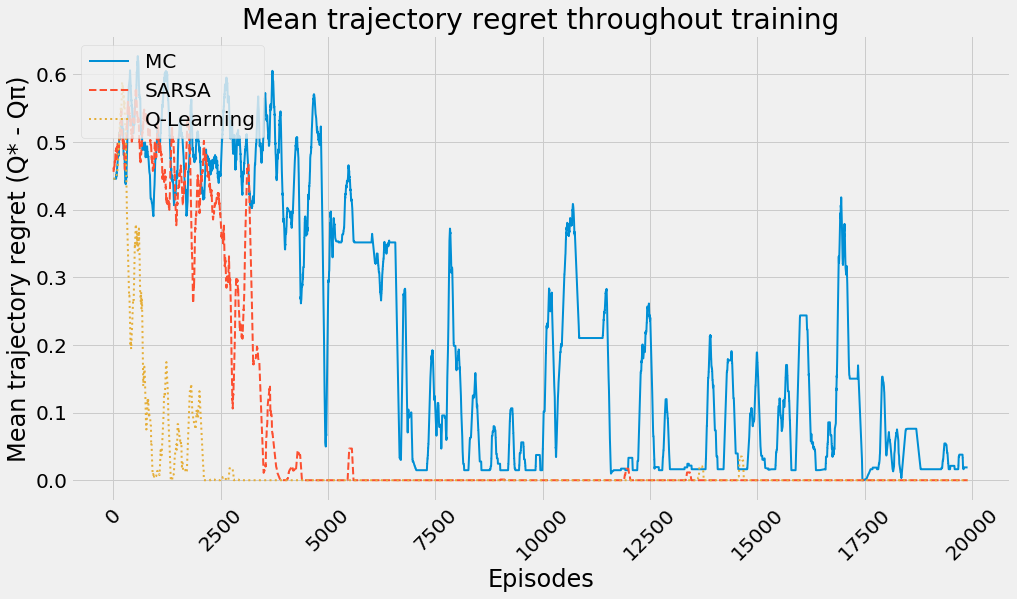

In [60]:
plt.plot(mc_regret_accumulation, '-', linewidth=2, label='MC')
plt.plot(sarsa_regret_accumulation, '--', linewidth=2, label='SARSA')
plt.plot(ql_regret_accumulation, ':', linewidth=2, label='Q-Learning')
plt.legend(loc=2, ncol=1)

plt.title('Mean trajectory regret throughout training')
plt.xlabel('Episodes')
plt.ylabel('Mean trajectory regret (Q* - Qπ)')
plt.xticks(rotation=45)

plt.show()

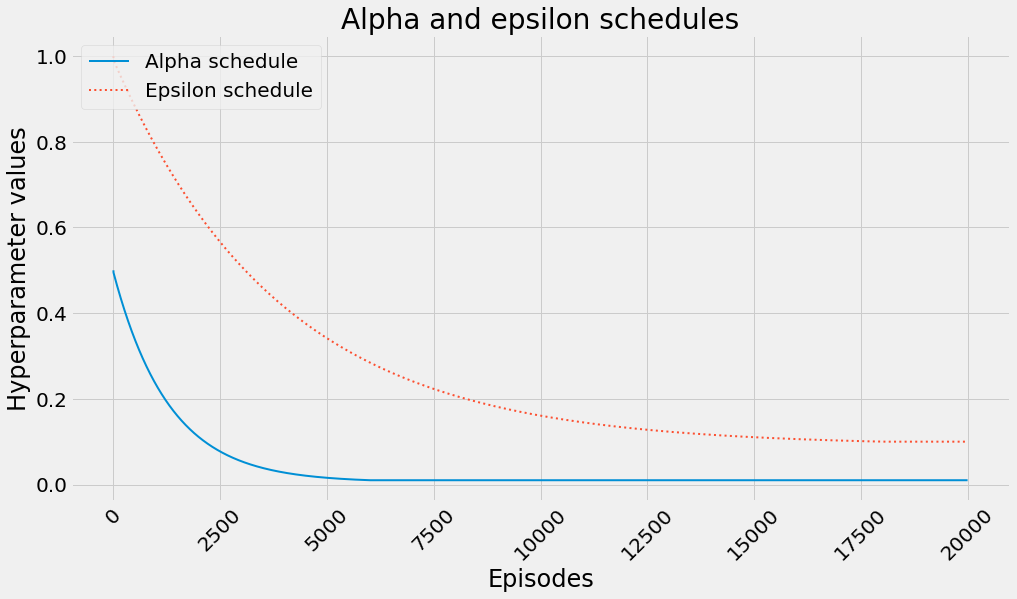

In [61]:
plt.plot([decay_schedule(0.5, 0.01, 0.3, 20000, i) for i in range(20000)], '-', linewidth=2, label='Alpha schedule')
plt.plot([decay_schedule(1.0, 0.1, 0.9, 20000, i) for i in range(20000)], ':', linewidth=2, label='Epsilon schedule')
plt.legend(loc=2, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()